## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [4]:
dataset_path = "/data/datasets/"
dataset = "AB_NYC_2019.csv"

In [5]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

In [6]:
df = pd.read_csv(f"{dataset_path}{dataset}", usecols=columns)
# fill with na the dataset
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [7]:
df.head(5)

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [8]:
# Applying log to price
df['price'] = np.log1p(df['price'])

In [11]:
df['price'].head(3)

0    5.010635
1    5.420535
2    5.017280
Name: price, dtype: float64

In [14]:
# split the dataset
df_train_full, df_test = train_test_split(df, test_size=.20, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=.25, random_state=1)

In [15]:
# reset the index :) 
df_train = df_train.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)

In [21]:
# Get target features
y_train = df_train['price'].values
y_test  = df_test['price'].values
y_val   = df_val['price'].values

del df_train['price']
del df_test['price']
del df_val['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [23]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.fillna(0).to_dict(orient='records')
val_dicts = df_val.fillna(0).to_dict(orient='records')

In [28]:
x_train = dv.fit_transform(train_dicts)
x_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [29]:
model = DecisionTreeRegressor(max_depth=1, random_state=1)
dt = model.fit(x_train, y_train)

In [31]:
dt

DecisionTreeRegressor(max_depth=1, random_state=1)

In [33]:
output = export_text(dt, feature_names=dv.get_feature_names())

/home/pymlboot/anaconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
print(output)

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

- [x] room_type
- [ ] `neighbourhood_group`
- [ ] `number_of_reviews`
- [ ] `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [37]:
model_rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf_tree = model_rf.fit(x_train, y_train)

In [40]:
# Get preds
y_preds = rf_tree.predict(x_val)

In [45]:
# Get the score
rmse = mean_squared_error(y_val, y_preds, squared=False)
print(round(rmse,4))

0.4599


What's the RMSE of this model on validation?

- [ ]  0.059
- [ ]  0.259
- [x] 0.459
- [ ] 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [52]:
rmses = {}
for n_estimator in range(10,201,10):
    model_rf = RandomForestRegressor(n_estimators=n_estimator,random_state=1,n_jobs=-1)
    rf_tree = model_rf.fit(x_train, y_train)
    y_preds = rf_tree.predict(x_val)
    rmse = mean_squared_error(y_val, y_preds, squared=False)
    rmses[n_estimator] = rmse

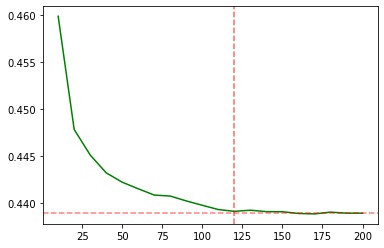

In [75]:
plt.plot(rmses.keys(), rmses.values(), color='green')
plt.axhline(y=.439,ls='--', color='red',alpha=0.5)
plt.axvline(x=120,ls='--', color='red', alpha=0.6)

After which value of `n_estimators` does RMSE stop improving?

- [ ] 10
- [ ] 50
- [ ] 70
- [x] 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [76]:
from itertools import product

In [89]:
max_depth = [10, 15, 20, 25]
n_estimators = list(range(10,201,10))

In [101]:
tuples = product(max_depth, n_estimators)
scores = []
for depth, n_estim in tuples:
    model_rf = RandomForestRegressor(max_depth=depth, 
                                     n_estimators=n_estim,
                                     random_state=1,
                                     n_jobs=-1)
    
    rf_tree = model_rf.fit(x_train, y_train)
    y_preds = rf_tree.predict(x_val)
    rmse = mean_squared_error(y_val, y_preds, squared=False)
    scores.append((depth, n_estim, rmse))

In [105]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [106]:
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.445596
1,10,20,0.442033
2,10,30,0.441392
3,10,40,0.441541
4,10,50,0.441120
...,...,...,...
75,25,160,0.439070
76,25,170,0.438917
77,25,180,0.439082
78,25,190,0.438973


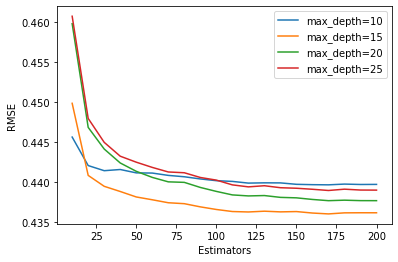

In [107]:
for depth in max_depth:
    df_subset = df_scores[df_scores.max_depth == depth]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % depth)
    plt.ylabel("RMSE")
    plt.xlabel("Estimators")

plt.legend()

What's the best `max_depth`:

- [ ] 10
- [x] 15
- [ ] 20
- [ ] 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [113]:
model_rf_q5 = RandomForestRegressor(max_depth=20, 
                                     n_estimators=10,
                                     random_state=1,
                                     n_jobs=-1)
    
rf_tree_q5 = model_rf_q5.fit(x_train, y_train)
model_rf_q5.feature_importances_

array([7.65657560e-02, 3.02638819e-02, 1.51755500e-01, 1.53475601e-01,
       5.31695975e-02, 4.47273475e-04, 1.11450114e-03, 3.40436593e-02,
       1.03414350e-03, 8.37127171e-05, 4.25185232e-02, 5.45945765e-02,
       3.91898023e-01, 4.87707077e-03, 4.15817992e-03])

In [118]:
std = np.std([tree.feature_importances_ for tree in model_rf_q5.estimators_], axis=0)

Text(0, 0.5, 'Mean decrease in impurity - MDI')

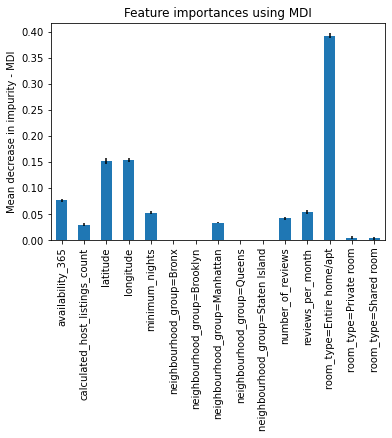

In [123]:
forest_importances = pd.Series(rf_tree_q5.feature_importances_, index=dv.get_feature_names_out())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity - MDI")


What's the most important feature? 

- [ ] neighbourhood_group=Manhattan
- [x] `room_type=Entire home/apt`	
- [ ] longitude
- [ ] latitude

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [172]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [221]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [222]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features)

In [276]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [277]:
%%capture output
xgb_params['eta'] = 0.3
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
              verbose_eval=10,
              evals=watchlist)
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [278]:
%%capture output

xgb_params['eta'] = 0.1
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
              verbose_eval=10,
              evals=watchlist)
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [279]:
%%capture output

xgb_params['eta'] = 0.01
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
              verbose_eval=10,
              evals=watchlist)
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

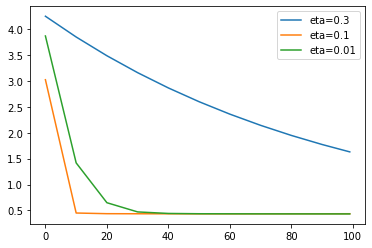

In [280]:
etas = list(scores.keys())
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.legend()

Now change `eta` first to `0.1` and then to `0.01`

What's the best eta?

- [ ] 0.3
- [x] 0.1
- [ ] 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

